### Utility functions


---



In [0]:
def getfeat(df):
    """
    Returns lists of numeric & categorical features
    """
    numfeat, catfeat = list(df.select_dtypes(include=np.number)), list(df.select_dtypes(exclude=np.number))
    return numfeat, catfeat



---


# IMPORTS

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set(style="darkgrid")

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [0]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/proj_5 - ML_for_banking/train.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/proj_5 - ML_for_banking/test.csv')
sample = pd.read_csv('drive/My Drive/Colab Notebooks/proj_5 - ML_for_banking/sample_submission.csv')

In [342]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [0]:
## Dropping the redundant column of 'Loan_ID'
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace=True)

In [0]:
## Seperating features by type and target column
target = 'Interest_Rate'
numfeat, catfeat = getfeat(train)
numfeat.remove(target)

temp = 0    ## a temporary variable for random usage

In [345]:
train.shape, test.shape

((164309, 13), (109541, 12))

# DATA PREPROCESSING

#### Target - Interest_Rate

In [0]:
## Mapping target variable to categories as integer type won't give best results. 
match = {1:'Cat_1', 2:'Cat_2', 3:'Cat_3'}  
unmatch = {'Cat_1': 1, 'Cat_2': 2, 'Cat_3':3} ## to be used during submission to unmap
train[target] = train[target].map(match)

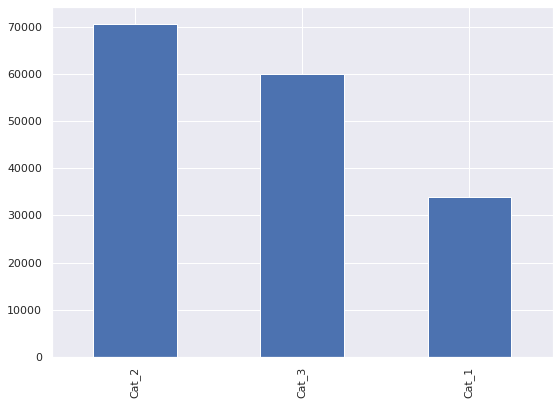

In [347]:
train[target].value_counts().plot(kind='bar', figsize=(8,6))
plt.show()  

In [0]:
# drop_indices = np.random.choice(train[train[target]=='Cat_2'].index, 30000, replace=False)
# train = train.drop(drop_indices).reset_index()
# drop_indices = np.random.choice(train[train[target]=='Cat_3'].index, 25000, replace=False)
# train = train.drop(drop_indices).reset_index()
# train[target].value_counts()
# # train.head()

In [349]:
train_labels = train[target]
df = pd.concat([train, test], keys = ['train', 'test'])
df

Loan_Amount_Requested Length_Employed  ...  Gender  Interest_Rate
train 0                      7,000        < 1 year  ...  Female          Cat_1
      1                     30,000         4 years  ...  Female          Cat_3
      2                     24,725         7 years  ...    Male          Cat_3
      3                     16,000        < 1 year  ...    Male          Cat_3
      4                     17,000         8 years  ...  Female          Cat_1
...                            ...             ...  ...     ...            ...
test  109536                15,000         9 years  ...    Male            NaN
      109537                 9,600       10+ years  ...    Male            NaN
      109538                 2,000         5 years  ...    Male            NaN
      109539                 2,125         6 years  ...    Male            NaN
      109540                15,000         2 years  ...    Male            NaN

[273850 rows x 13 columns]


The data looks imbalanced as class '2' has around 70000 cases and class '1' has around 33000 cases. 
One might be motivated to balance out the data to remove bias from the model for starters. But [this](https://matloff.wordpress.com/2015/09/29/unbalanced-data-is-a-problem-no-balanced-data-is-worse/) article explains quite well how 'the problem of (artificially) balanced data is worse than the unbalanced case'. 

Hence, moving on with the data.

---
---

#### 1: Loan_Amount_Requested

In [350]:
## Beginner mistakes
    # for temp in range(len(df['Loan_Amount_Requested'])):
    #     df['Loan_Amount_Requested'][temp] = int(df['Loan_Amount_Requested'][temp].replace(',', ''))
    # df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].astype('int64')
## First I was using the above loop to do the following. But the found the better efficient way of doing it from a friend.

## Fixing 'Loan_Amount_Requested' 
df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(",","").astype('int64')
df['Loan_Amount_Requested'].unique()

array([ 7000, 30000, 24725, ..., 32700, 33450, 34425])

In [0]:
## Creating new features before moving towards transformation
df['Loan_Amount_Requested_range'] = pd.cut(df['Loan_Amount_Requested'], 
                                             bins= range(0, df['Loan_Amount_Requested'].max(), 2000)).astype('object')
df['Loan_Amount_Requested_category'] = pd.cut(df['Loan_Amount_Requested'], 
                                                 bins=[int(x) for x in np.linspace(0,df['Loan_Amount_Requested'].max(), 8)], 
                                                 labels=['Very Low', 'Low', 'Medium-Low', 'Medium', 'Medium-High', 'High', 'Very High']).astype('object')

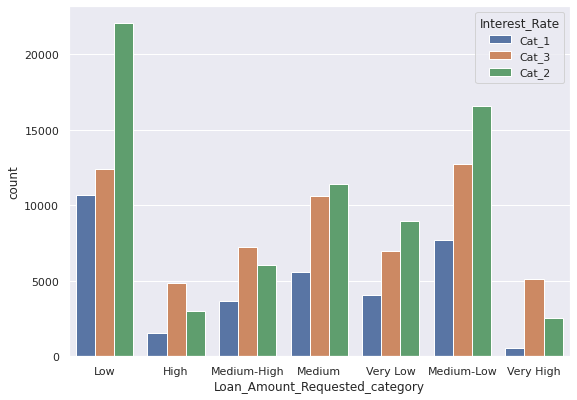

In [352]:
sns.countplot(x = 'Loan_Amount_Requested_category', data = df.xs('train'), hue = 'Interest_Rate')
plt.show()

Category 2 seems to be most famous loan for a lot of loan amounts (except the highest one). Category 3 shows an interesting and unidentifiable trend. Category 1 is the least favoured for all types.



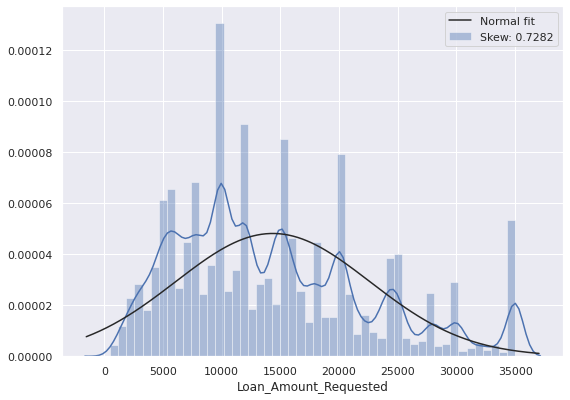

In [353]:
sns.distplot(df['Loan_Amount_Requested'], fit = stats.norm)
plt.legend(['Normal fit', 'Skew: {:.4f}'.format(df['Loan_Amount_Requested'].skew())])
plt.show()

#### 2: Length_Employed

In [354]:
temp = 'Length_Employed'
df[temp].isnull().sum()/len(df[temp])*100

4.494066094577323

Around 4.5% data is null for Length_Employed. First job is to fill the null values. Looking for a method to fill the values.

In [355]:
df[temp].unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

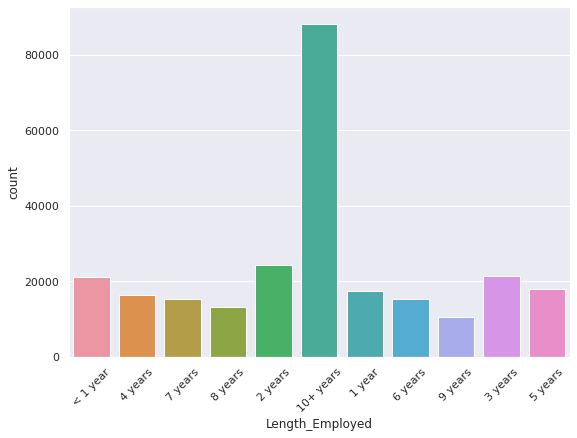

In [356]:
sns.countplot(x=temp, data = df)
plt.xticks(rotation=45)
plt.show()

In [0]:
## My guesses for null values --> either unemployed i.e. a housewife or student in that case '0 year' 
##                            --> fill with mode 

df[temp].fillna('0 year', inplace=True)

#### 3: Home_Owner

In [358]:
temp = 'Home_Owner'
df[temp].isnull().sum()/len(df)*100

15.358773050940297

In [359]:
df[temp].value_counts()

Mortgage    117270
Rent         93542
Own          20879
Other           79
None            20
Name: Home_Owner, dtype: int64

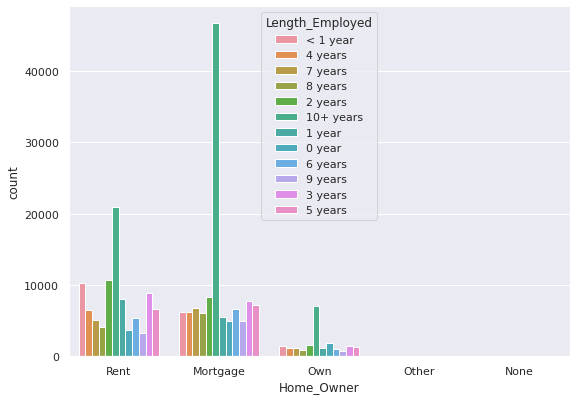

In [360]:
sns.countplot(temp, data=df, hue='Length_Employed')
plt.show()

In [0]:
## My guesses for null values --> people let go of filling just because none of it applies
##                            --> fill with mode 

df[temp].fillna('None', inplace = True)

#### 4: Annual_Income

In [362]:
temp = 'Annual_Income'
df[temp].isnull().sum()/len(df)*100

15.33686324630272

In [363]:
df[temp].describe()

count    2.318500e+05
mean     7.339279e+04
std      5.852984e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.900000e+04
max      7.500000e+06
Name: Annual_Income, dtype: float64

In [0]:
## My guesses for null values --> fill with median as data has an extreme outlier
##                            -->  
df[temp].fillna(df[temp].median(), inplace=True)

In [0]:
df['Annual_Income_range'] = pd.cut(df[temp], bins=[int(x) for x in np.linspace(0, df[temp].max(), 15)]).astype('object')
df['Annual_Income_cat'] = pd.cut(df[temp], bins=[int(x) for x in np.linspace(0, df[temp].max(), 8)],
                                 labels = ['Very Low', 'Low', 'Medium-Low', 'Medium', 'Medium-High', 'High', 'Very High']).astype('object')

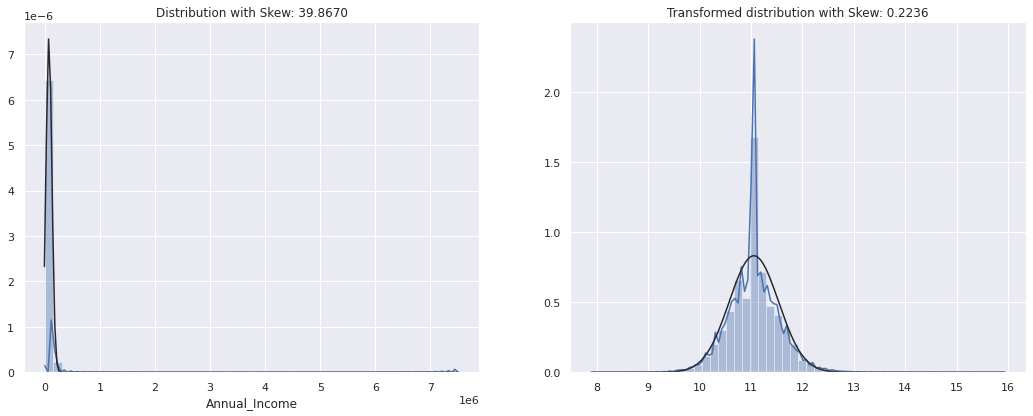

In [366]:
f,a = plt.subplots(1,2,figsize=(16,6))

sns.distplot(df[temp], fit=stats.norm, ax=a[0])
a[0].set_title("Distribution with Skew: {:.4f}".format(df[temp].skew()))

tempdf = pd.Series(stats.boxcox(1+df[temp], lmbda=0))

sns.distplot(tempdf, fit=stats.norm, ax=a[1])
a[1].set_title("Transformed distribution with Skew: {:.4f}".format(tempdf.skew()))

df[temp] = stats.boxcox(1+df[temp], lmbda=0)
plt.show()

A highly skewed feature.

---

#### 5: Income_Verified

In [367]:
temp = 'Income_Verified'
df[temp].isnull().sum()

0

In [368]:
df[temp].unique()

array(['not verified', 'VERIFIED - income', 'VERIFIED - income source'],
      dtype=object)

#### 6: Purpose_Of_Loan

In [369]:
temp = 'Purpose_Of_Loan'
df[temp].isnull().sum()

0

In [370]:
df[temp].unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype=object)

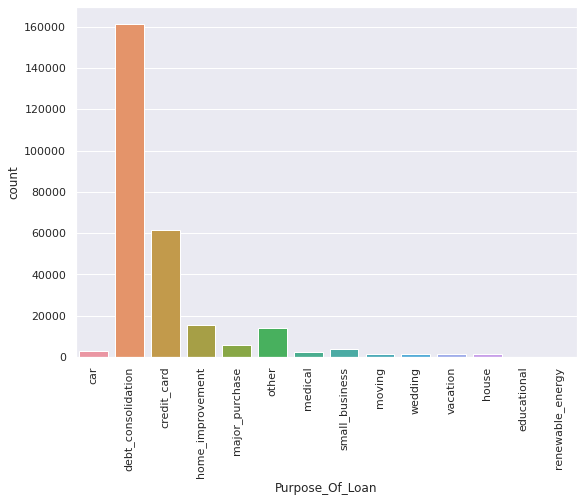

In [371]:
sns.countplot(df[temp])
plt.xticks(rotation=90)
plt.show()

#### 7: Debt_To_Income

In [372]:
temp = 'Debt_To_Income'
df[temp].isnull().sum()

0

In [373]:
df[temp].describe(percentiles=[0.20,0.40,0.60,0.9])

count    273850.000000
mean         17.215901
std           7.845967
min           0.000000
20%          10.120000
40%          14.710000
50%          16.850000
60%          19.060000
90%          28.010000
max          39.990000
Name: Debt_To_Income, dtype: float64

In [0]:
df['Debt'] = (df[temp]*df['Annual_Income']).astype('float')

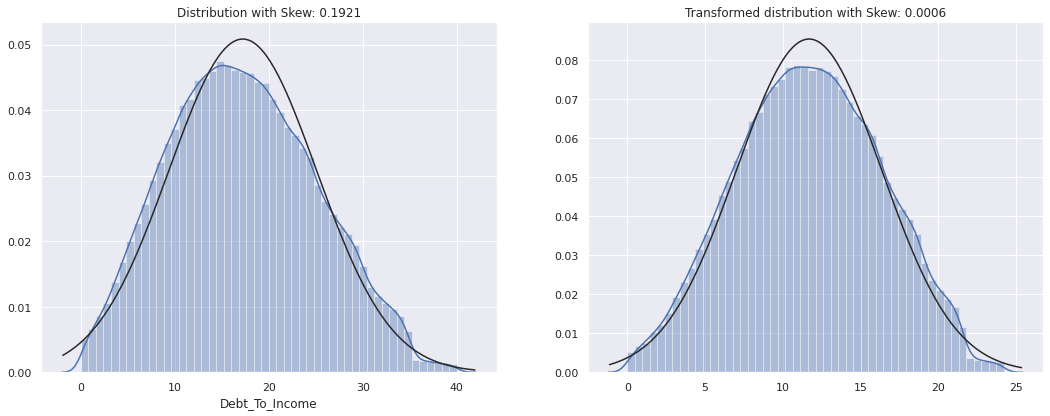

In [375]:
f,a = plt.subplots(1,2,figsize=(16,6))

sns.distplot(df[temp], fit=stats.norm, ax=a[0])
a[0].set_title("Distribution with Skew: {:.4f}".format(df[temp].skew()))

tempdf = pd.Series(stats.boxcox(1+df[temp], lmbda=0.817))

sns.distplot(tempdf, fit=stats.norm, ax=a[1])
a[1].set_title("Transformed distribution with Skew: {:.4f}".format(tempdf.skew()))

df[temp] = stats.boxcox(1+df[temp], lmbda=0.817)
plt.show()

#### 8: Inquiries_Last_6Mo

In [376]:
temp = 'Inquiries_Last_6Mo'
df[temp].isnull().sum()

0

In [377]:
sorted(df[temp].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [0]:
df['Requirement'] = pd.cut(df[temp], bins=[0,1,5,8], labels = ['least', 'wanted', 'highly wanted']).astype('object')

#### 9: Months_Since_Deliquency

In [379]:
temp = 'Months_Since_Deliquency'
df[temp].isnull().sum()/len(df)*100

53.765930253788575

In [0]:
df.drop(temp, axis=1,inplace=True)

#### 10: Number_Open_Accounts

In [381]:
temp = 'Number_Open_Accounts'
print(df[temp].isnull().sum(), sorted(df[temp].unique()))

0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 61, 62, 76, 84]


In [0]:
df['Number_Open_Accounts_cat'] = pd.cut(df[temp], bins = [0,9,20,45,85], labels=['few', 'ok_ok', 'many', 'far_too_many']).astype('object')

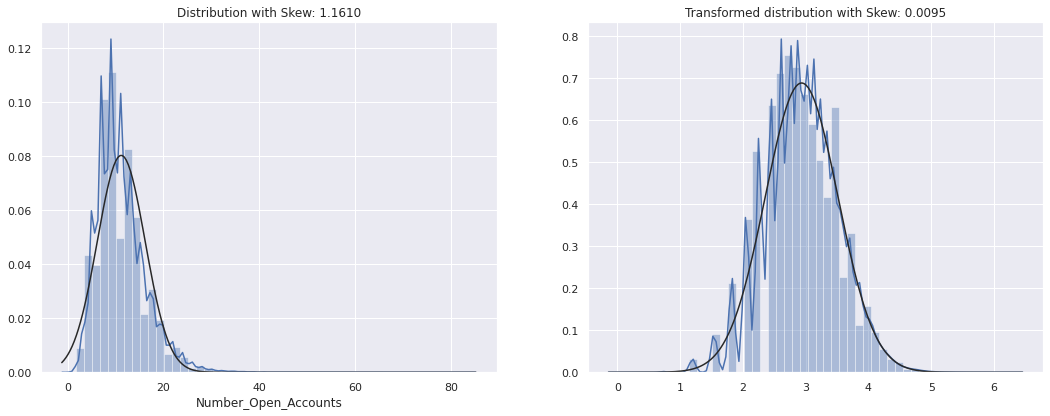

In [383]:
f,a = plt.subplots(1,2,figsize=(16,6))

sns.distplot(df[temp], fit=stats.norm, ax=a[0])
a[0].set_title("Distribution with Skew: {:.4f}".format(df[temp].skew()))

tempdf = pd.Series(stats.boxcox(1+df[temp], lmbda=0.15))

sns.distplot(tempdf, fit=stats.norm, ax=a[1])
a[1].set_title("Transformed distribution with Skew: {:.4f}".format(tempdf.skew()))

df[temp] = stats.boxcox(1+df[temp], lmbda=0.15) ##    ONE TIME RUN
plt.show()

#### 11: Total_Accounts

In [384]:
temp = 'Total_Accounts'
df[temp].isnull().sum()

0

In [385]:
df[temp].describe()

count    273850.000000
mean         25.067975
std          11.589677
min           2.000000
25%          17.000000
50%          23.000000
75%          32.000000
max         156.000000
Name: Total_Accounts, dtype: float64

In [0]:
df['Total_Accounts_cat'] = pd.cut(df[temp], bins = [0,9,20,45,85,156], labels=['few', 'ok_ok', 'many', 'very_many','far_too_many']).astype('object')

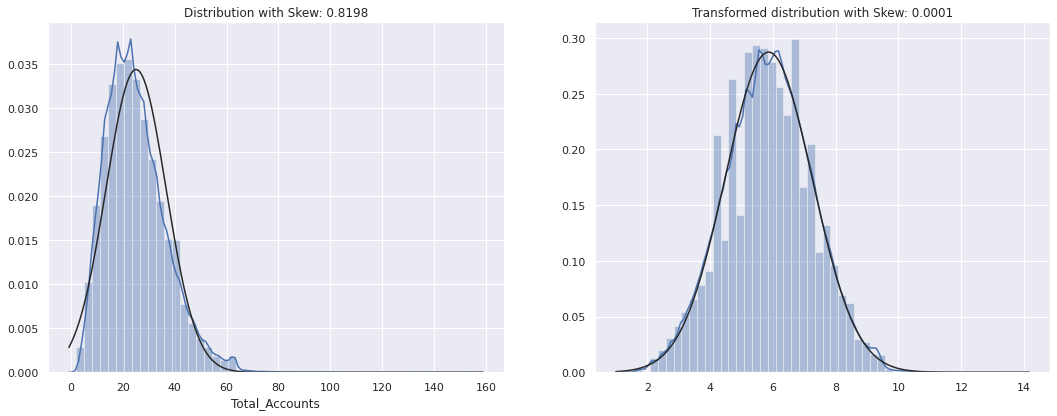

In [387]:
f,a = plt.subplots(1,2,figsize=(16,6))

sns.distplot(df[temp], fit=stats.norm, ax=a[0])
a[0].set_title("Distribution with Skew: {:.4f}".format(df[temp].skew()))

tempdf = pd.Series(stats.boxcox(1+df[temp], lmbda=0.348))

sns.distplot(tempdf, fit=stats.norm, ax=a[1])
a[1].set_title("Transformed distribution with Skew: {:.4f}".format(tempdf.skew()))

df[temp] = stats.boxcox(1+df[temp], lmbda=0.348) ##    ONE TIME RUN
plt.show()

#### 12: Gender

In [388]:
temp = 'Gender'
df[temp].isnull().sum()

0



---




# MODEL FITTING

In [0]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# !pip install catboost
from catboost import CatBoostClassifier

## Data Prepping

In [0]:
numfeat, catfeat = getfeat(df)
catfeat.remove(target)

In [0]:
X = df.xs('train').drop(target, axis=1)
y = df.xs('train')[target]

X_test = df.xs('test').drop(target, axis=1)

In [392]:
X.shape, y.shape, X_test.shape

((164309, 19), (164309,), (109541, 19))

In [393]:
X = pd.get_dummies(X, columns=catfeat)
X_test = pd.get_dummies(X_test, columns=catfeat)

from sklearn import preprocessing as prep

minmaxscalar = prep.MinMaxScaler()
X = pd.DataFrame(minmaxscalar.fit_transform(X), columns = X.columns)
X_test = pd.DataFrame(minmaxscalar.fit_transform(X_test), columns = X_test.columns)

X.shape, y.shape, X_test.shape

((164309, 92), (164309,), (109541, 87))

In [0]:
kf = KFold(n_splits=5, shuffle=True)

X_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

## LightGB 

#### Parameter tuning


In [0]:
learning_rate = [float(x) for x in np.linspace(0.005, 0.05, 1000)]
n_estimators = [int(x) for x in range(500,5000,500)]
max_depth = [int(x) for x in range(2,30,2)]
num_leaves = [int(x) for x in range(1,5000,100)]
bagging_fraction = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

early_stopping_rounds = 50
min_data_in_leaf = 100
lambda_l1 = 0.5

lgbgrid = {'num_leaves': num_leaves,
           'bagging_fraction': bagging_fraction,
           'early_stopping_rounds': early_stopping_rounds,
           'min_data_in_leaf': min_data_in_leaf,
           'lambda_l1': lambda_l1,
           'max_depth': max_depth,
           'n_estimators': n_estimators,
           'learning_rate': learning_rate
           }

In [0]:
# lgbm = lgb.LGBMClassifier(objective='multiclass', random_state=5, bagging_freq=1)
# clf = RandomizedSearchCV(lgbm, lgbgrid, cv=5, n_iter=300, n_jobs=1)
# search = clf.fit(X_train,y_train)
# search.best_params_

#### Model training

In [0]:
scores = {'last':0,'current':0}

In [151]:
lgbm = lgb.LGBMClassifier(boost = 'dart', objective='multiclass', num_class = 3,
                          learning_rate = 0.075, max_bin = 470,
                          max_depth = 38, min_data_in_leaf = 60, num_leaves = 3501,
                          lambda_l1 = 0.5                          
                          )

lgbm.fit(X_train, y_train,early_stopping_rounds=100, verbose=200)

y_pred = lgbm.predict(x_test)

scores['current'] = f1_score(y_test, y_pred, average='weighted')
print('\nprevious score = ', scores['last'],
      '\ncurrent score = ', scores['current'])
scores['last'] = scores['current']


previous score =  0 
current score =  0.5006713088500805


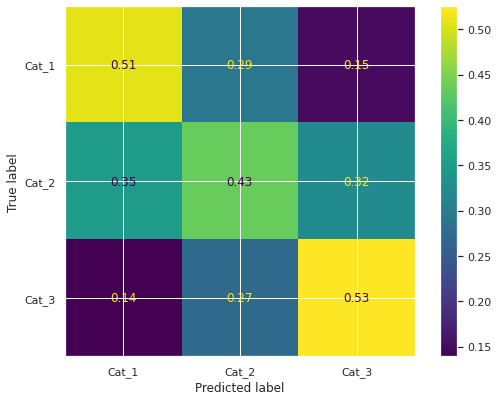

In [65]:
plot_confusion_matrix(lgbm, x_test, y_test, normalize='pred')
plt.show()

## Neural Network

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoded_y = LabelEncoder().fit_transform(y_train)
dummy_y = np_utils.to_categorical(encoded_y)

encoded_y_test = LabelEncoder().fit_transform(y_test)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [403]:
model = Sequential()
model.add(Dense(12, input_dim=92 ,activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

model.fit(X_train,dummy_y,epochs=100, validation_split=0.1,batch_size=128, verbose=100)


Train on 118302 samples, validate on 13145 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/

In [417]:
f1_sc = model.evaluate(x_test, dummy_y_test, verbose=0, batch_size=32)
f1_sc[1]

0.4103630483150482

# SUBMISSION

In [0]:
sub = pd.Series(lgbm.predict(X_test))

In [0]:
sample.iloc[:,1] = sub.map(unmatch)

In [0]:
sample.head()

In [0]:
sample.to_csv('drive/My Drive/Colab Notebooks/proj_5 - ML_for_banking/first.csv', index=False)